## Assignment 4 - Helper Functions
# Apriori

We begin by including the functions to generate frequent itemsets (via the Apriori algorithm) and resulting association rules:

In [6]:
# (c) 2016 Everaldo Aguiar & Reid Johnson
#
# Modified from:
# Marcel Caraciolo (https://gist.github.com/marcelcaraciolo/1423287)
#
# Functions to compute and extract association rules from a given frequent itemset 
# generated by the Apriori algorithm.
#
# The Apriori algorithm is defined by Agrawal and Srikant in:
# Fast algorithms for mining association rules
# Proc. 20th int. conf. very large data bases, VLDB. Vol. 1215. 1994
import csv
import numpy as np

def load_dataset(filename):
    '''Loads an example of market basket transactions from a provided csv file.

    Returns: A list (database) of lists (transactions). Each element of a transaction is 
    an item.
    '''

    with open(filename,'r') as dest_f:
        data_iter = csv.reader(dest_f, delimiter = ',', quotechar = '"')
        #data = [data for data in data_iter]
        data = [transaction for transaction in data_iter if transaction]  # This ensures empty lines are ignored
        data_array = np.asarray(data)
        
    return data_array

def apriori(dataset, min_support=0.5, verbose=False):
    """Implements the Apriori algorithm.

    The Apriori algorithm will iteratively generate new candidate 
    k-itemsets using the frequent (k-1)-itemsets found in the previous 
    iteration.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate 
        candidate itemsets.

    min_support : float
        The minimum support threshold. Defaults to 0.5.

    Returns
    -------
    F : list
        The list of frequent itemsets.

    support_data : dict
        The support data for all candidate itemsets.

    References
    ----------
    .. [1] R. Agrawal, R. Srikant, "Fast Algorithms for Mining Association 
           Rules", 1994.

    """
    C1 = create_candidates(dataset)
    D = list(map(set, dataset))
    F1, support_data = support_prune(D, C1, min_support, verbose=False) # prune candidate 1-itemsets
    F = [F1] # list of frequent itemsets; initialized to frequent 1-itemsets
    k = 2 # the itemset cardinality
    while (len(F[k - 2]) > 0):
        Ck = apriori_gen(F[k-2], k) # generate candidate itemsets
        Fk, supK = support_prune(D, Ck, min_support) # prune candidate itemsets
        support_data.update(supK) # update the support counts to reflect pruning
        F.append(Fk) # add the pruned candidate itemsets to the list of frequent itemsets
        k += 1

    if verbose:
        # Print a list of all the frequent itemsets.
        for kset in F:
            for item in kset:
                print("" \
                    + "{" \
                    + "".join(str(i) + ", " for i in iter(item)).rstrip(', ') \
                    + "}" \
                    + ":  sup = " + str(round(support_data[item], 3)))

    return F, support_data

def create_candidates(dataset, verbose=False):
    """Creates a list of candidate 1-itemsets from a list of transactions.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate candidate 
        itemsets.

    Returns
    -------
    The list of candidate itemsets (c1) passed as a frozenset (a set that is 
    immutable and hashable).
    """
    c1 = [] # list of all items in the database of transactions
    for transaction in dataset:
        for item in transaction:
            if not [item] in c1:
                c1.append([item])
    c1.sort()

    if verbose:
        # Print a list of all the candidate items.
        print("" \
            + "{" \
            + "".join(str(i[0]) + ", " for i in iter(c1)).rstrip(', ') \
            + "}")

    # Map c1 to a frozenset because it will be the key of a dictionary.
    return list(map(frozenset, c1))

def support_prune(dataset, candidates, min_support, verbose=False):
    """Returns all candidate itemsets that meet a minimum support threshold.

    By the apriori principle, if an itemset is frequent, then all of its 
    subsets must also be frequent. As a result, we can perform support-based 
    pruning to systematically control the exponential growth of candidate 
    itemsets. Thus, itemsets that do not meet the minimum support level are 
    pruned from the input list of itemsets (dataset).

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate candidate 
        itemsets.

    candidates : frozenset
        The list of candidate itemsets.

    min_support : float
        The minimum support threshold.

    Returns
    -------
    retlist : list
        The list of frequent itemsets.

    support_data : dict
        The support data for all candidate itemsets.
    """
    sscnt = {} # set for support counts
    for tid in dataset:
        for can in candidates:
            if can.issubset(tid):
                sscnt.setdefault(can, 0)
                sscnt[can] += 1

    num_items = float(len(dataset)) # total number of transactions in the dataset
    retlist = [] # array for unpruned itemsets
    support_data = {} # set for support data for corresponding itemsets
    for key in sscnt:
        # Calculate the support of itemset key.
        support = sscnt[key] / num_items
        if support >= min_support:
            retlist.insert(0, key)
        support_data[key] = support

    # Print a list of the pruned itemsets.
    if verbose:
        for kset in retlist:
            for item in kset:
                print("{" + str(item) + "}")
        print("")
        for key in sscnt:
            print("" \
                + "{" \
                + "".join([str(i) + ", " for i in iter(key)]).rstrip(', ') \
                + "}" \
                + ":  sup = " + str(support_data[key]))

    return retlist, support_data

def apriori_gen(freq_sets, k):
    """Generates candidate itemsets (via the F_k-1 x F_k-1 method).

    This operation generates new candidate k-itemsets based on the frequent 
    (k-1)-itemsets found in the previous iteration. The candidate generation 
    procedure merges a pair of frequent (k-1)-itemsets only if their first k-2 
    items are identical.

    Parameters
    ----------
    freq_sets : list
        The list of frequent (k-1)-itemsets.

    k : integer
        The cardinality of the current itemsets being evaluated.

    Returns
    -------
    retlist : list
        The list of merged frequent itemsets.
    """
    retList = [] # list of merged frequent itemsets
    lenLk = len(freq_sets) # number of frequent itemsets
    for i in range(lenLk):
        for j in range(i+1, lenLk):
            a=list(freq_sets[i])
            b=list(freq_sets[j])
            a.sort()
            b.sort()
            F1 = a[:k-2] # first k-2 items of freq_sets[i]
            F2 = b[:k-2] # first k-2 items of freq_sets[j]

            if F1 == F2: # if the first k-2 items are identical
                # Merge the frequent itemsets.
                retList.append(freq_sets[i] | freq_sets[j])

    return retList

def rules_from_conseq(freq_set, H, support_data, rules, min_confidence=0.5, verbose=False):
    """Generates a set of candidate rules.

    Parameters
    ----------
    freq_set : frozenset
        The complete list of frequent itemsets.

    H : list
        A list of frequent itemsets (of a particular length).

    support_data : dict
        The support data for all candidate itemsets.

    rules : list
        A potentially incomplete set of candidate rules above the minimum 
        confidence threshold.

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.
    """
    m = len(H[0])
    if m == 1:
        Hmp1 = calc_confidence(freq_set, H, support_data, rules, min_confidence, verbose)
    if (len(freq_set) > (m+1)):
        Hmp1 = apriori_gen(H, m+1) # generate candidate itemsets
        Hmp1 = calc_confidence(freq_set, Hmp1, support_data, rules, min_confidence, verbose)
        if len(Hmp1) > 1:
            # If there are candidate rules above the minimum confidence 
            # threshold, recurse on the list of these candidate rules.
            rules_from_conseq(freq_set, Hmp1, support_data, rules, min_confidence, verbose)

def calc_confidence(freq_set, H, support_data, rules, min_confidence=0.5, verbose=False):
    """Evaluates the generated rules.

    One measurement for quantifying the goodness of association rules is 
    confidence. The confidence for a rule 'P implies H' (P -> H) is defined as 
    the support for P and H divided by the support for P 
    (support (P|H) / support(P)), where the | symbol denotes the set union 
    (thus P|H means all the items in set P or in set H).

    To calculate the confidence, we iterate through the frequent itemsets and 
    associated support data. For each frequent itemset, we divide the support 
    of the itemset by the support of the antecedent (left-hand-side of the 
    rule).

    Parameters
    ----------
    freq_set : frozenset
        The complete list of frequent itemsets.

    H : list
        A list of frequent itemsets (of a particular length).

    min_support : float
        The minimum support threshold.

    rules : list
        A potentially incomplete set of candidate rules above the minimum 
        confidence threshold.

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.

    Returns
    -------
    pruned_H : list
        The list of candidate rules above the minimum confidence threshold.
    """
    pruned_H = [] # list of candidate rules above the minimum confidence threshold
    for conseq in H: # iterate over the frequent itemsets
        conf = support_data[freq_set] / support_data[freq_set - conseq]
        if conf >= min_confidence:
            rules.append((freq_set - conseq, conseq, conf))
            pruned_H.append(conseq)

            if verbose:
                print("" \
                    + "{" \
                    + "".join([str(i) + ", " for i in iter(freq_set-conseq)]).rstrip(', ') \
                    + "}" \
                    + " ---> " \
                    + "{" \
                    + "".join([str(i) + ", " for i in iter(conseq)]).rstrip(', ') \
                    + "}" \
                    + ":  conf = " + str(round(conf, 3)) \
                    + ", sup = " + str(round(support_data[freq_set], 3)))

    return pruned_H

def generate_rules(F, support_data, min_confidence=0.5, verbose=True):
    """Generates a set of candidate rules from a list of frequent itemsets.

    For each frequent itemset, we calculate the confidence of using a
    particular item as the rule consequent (right-hand-side of the rule). By 
    testing and merging the remaining rules, we recursively create a list of 
    pruned rules.

    Parameters
    ----------
    F : list
        A list of frequent itemsets.

    support_data : dict
        The corresponding support data for the frequent itemsets (L).

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.

    Returns
    -------
    rules : list
        The list of candidate rules above the minimum confidence threshold.
    """
    rules = []
    for i in range(1, len(F)):
        for freq_set in F[i]:
            H1 = [frozenset([itemset]) for itemset in freq_set]
            if (i > 1):
                rules_from_conseq(freq_set, H1, support_data, rules, min_confidence, verbose)
            else:
                calc_confidence(freq_set, H1, support_data, rules, min_confidence, verbose)

    return rules

### To load our dataset of grocery transactions, use the command below

In [15]:
import csv

def load_dataset(filename):
    transactions = []
    with open(filename, 'r', encoding='utf-8') as file:
        data_iter = csv.reader(file, delimiter=',', quotechar='"')
        for row in data_iter:
            # Convert each row to a set to handle variable-length transactions
            transactions.append(set(row))
    return transactions

# Path to the grocery dataset CSV file
file_path = 'grocery.csv'

# Load the dataset
dataset = load_dataset(file_path)
D = list(map(set, dataset))

In [16]:
type(dataset)

list

In [17]:
dataset[0]

{'citrus fruit', 'margarine', 'ready soups', 'semi-finished bread'}

In [18]:
dataset[1]

{'coffee', 'tropical fruit', 'yogurt'}

### _D_ Contains that dataset in a set format (which excludes duplicated items and sorts them)

In [19]:
type(dataset[0])

set

In [20]:
D[0]

{'citrus fruit', 'margarine', 'ready soups', 'semi-finished bread'}

# Complete the assignment below by making use of the provided funtions. 

## You may use the notebook file attached with lesson 3 as a reference

In [21]:
# Print out the rules
def print_rules(rules, support_data):
    for rule in rules:
        print(f"Rule: {rule[0]} -> {rule[1]}")
        print(f"Confidence: {rule[2]}")
        print(f"Support: {support_data[rule[0] | rule[1]]}")
        print("----------")

In [22]:
# Set the minimum support and confidence values as required for your dataset
min_support = 0.05  # 5 Percent
min_confidence = 0.5  # 50 Percent

# Apply the Apriori algorithm to the dataset with the specified minimum support
frequent_itemsets, support_data = apriori(dataset, min_support=min_support, verbose=True)

# Generate the association rules from the frequent itemsets
rules = generate_rules(frequent_itemsets, support_data, min_confidence=min_confidence, verbose=True)

print_rules(rules, support_data)

{domestic eggs}:  sup = 0.063
{whipped/sour cream}:  sup = 0.072
{pork}:  sup = 0.058
{napkins}:  sup = 0.052
{shopping bags}:  sup = 0.099
{brown bread}:  sup = 0.065
{sausage}:  sup = 0.094
{canned beer}:  sup = 0.078
{root vegetables}:  sup = 0.109
{pastry}:  sup = 0.089
{newspapers}:  sup = 0.08
{fruit/vegetable juice}:  sup = 0.072
{soda}:  sup = 0.174
{frankfurter}:  sup = 0.059
{beef}:  sup = 0.052
{curd}:  sup = 0.053
{bottled water}:  sup = 0.111
{bottled beer}:  sup = 0.081
{rolls/buns}:  sup = 0.184
{butter}:  sup = 0.055
{other vegetables}:  sup = 0.193
{pip fruit}:  sup = 0.076
{whole milk}:  sup = 0.256
{yogurt}:  sup = 0.14
{tropical fruit}:  sup = 0.105
{coffee}:  sup = 0.058
{margarine}:  sup = 0.059
{citrus fruit}:  sup = 0.083
{rolls/buns, whole milk}:  sup = 0.057
{yogurt, whole milk}:  sup = 0.056
{other vegetables, whole milk}:  sup = 0.075


In [23]:
# Set the minimum support and confidence values as required for your dataset
min_support = 0.04  # 4 Percent
min_confidence = 0.5  # 50 Percent

# Apply the Apriori algorithm to the dataset with the specified minimum support
frequent_itemsets, support_data = apriori(dataset, min_support=min_support, verbose=True)

# Generate the association rules from the frequent itemsets
rules = generate_rules(frequent_itemsets, support_data, min_confidence=min_confidence, verbose=True)

print_rules(rules, support_data)

{frozen vegetables}:  sup = 0.048
{domestic eggs}:  sup = 0.063
{whipped/sour cream}:  sup = 0.072
{pork}:  sup = 0.058
{napkins}:  sup = 0.052
{shopping bags}:  sup = 0.099
{brown bread}:  sup = 0.065
{sausage}:  sup = 0.094
{canned beer}:  sup = 0.078
{root vegetables}:  sup = 0.109
{pastry}:  sup = 0.089
{newspapers}:  sup = 0.08
{fruit/vegetable juice}:  sup = 0.072
{chicken}:  sup = 0.043
{soda}:  sup = 0.174
{frankfurter}:  sup = 0.059
{beef}:  sup = 0.052
{curd}:  sup = 0.053
{white bread}:  sup = 0.042
{chocolate}:  sup = 0.05
{bottled water}:  sup = 0.111
{bottled beer}:  sup = 0.081
{rolls/buns}:  sup = 0.184
{butter}:  sup = 0.055
{other vegetables}:  sup = 0.193
{pip fruit}:  sup = 0.076
{whole milk}:  sup = 0.256
{yogurt}:  sup = 0.14
{tropical fruit}:  sup = 0.105
{coffee}:  sup = 0.058
{margarine}:  sup = 0.059
{citrus fruit}:  sup = 0.083
{yogurt, other vegetables}:  sup = 0.043
{rolls/buns, whole milk}:  sup = 0.057
{soda, whole milk}:  sup = 0.04
{root vegetables, who

In [24]:
# Set the minimum support and confidence values as required for your dataset
min_support = 0.03  # 3 Percent
min_confidence = 0.5  # 50 Percent

# Apply the Apriori algorithm to the dataset with the specified minimum support
frequent_itemsets, support_data = apriori(dataset, min_support=min_support, verbose=True)

# Generate the association rules from the frequent itemsets
rules = generate_rules(frequent_itemsets, support_data, min_confidence=min_confidence, verbose=True)

print_rules(rules, support_data)

{onions}:  sup = 0.031
{specialty chocolate}:  sup = 0.03
{frozen vegetables}:  sup = 0.048
{domestic eggs}:  sup = 0.063
{dessert}:  sup = 0.037
{whipped/sour cream}:  sup = 0.072
{pork}:  sup = 0.058
{berries}:  sup = 0.033
{napkins}:  sup = 0.052
{hygiene articles}:  sup = 0.033
{hamburger meat}:  sup = 0.033
{shopping bags}:  sup = 0.099
{brown bread}:  sup = 0.065
{sausage}:  sup = 0.094
{canned beer}:  sup = 0.078
{waffles}:  sup = 0.038
{salty snack}:  sup = 0.038
{root vegetables}:  sup = 0.109
{pastry}:  sup = 0.089
{sugar}:  sup = 0.034
{newspapers}:  sup = 0.08
{fruit/vegetable juice}:  sup = 0.072
{chicken}:  sup = 0.043
{soda}:  sup = 0.174
{frankfurter}:  sup = 0.059
{beef}:  sup = 0.052
{curd}:  sup = 0.053
{white bread}:  sup = 0.042
{chocolate}:  sup = 0.05
{bottled water}:  sup = 0.111
{bottled beer}:  sup = 0.081
{UHT-milk}:  sup = 0.033
{rolls/buns}:  sup = 0.184
{butter}:  sup = 0.055
{other vegetables}:  sup = 0.193
{long life bakery product}:  sup = 0.037
{pip fr

In [25]:
# Set the minimum support and confidence values as required for your dataset
min_support = 0.02  # 2 Percent
min_confidence = 0.5  # 50 Percent

# Apply the Apriori algorithm to the dataset with the specified minimum support
frequent_itemsets, support_data = apriori(dataset, min_support=min_support, verbose=True)

# Generate the association rules from the frequent itemsets
rules = generate_rules(frequent_itemsets, support_data, min_confidence=min_confidence, verbose=True)

print_rules(rules, support_data)

{meat}:  sup = 0.026
{sliced cheese}:  sup = 0.025
{onions}:  sup = 0.031
{frozen meals}:  sup = 0.028
{specialty chocolate}:  sup = 0.03
{frozen vegetables}:  sup = 0.048
{ice cream}:  sup = 0.025
{oil}:  sup = 0.028
{chewing gum}:  sup = 0.021
{ham}:  sup = 0.026
{cat food}:  sup = 0.023
{hard cheese}:  sup = 0.025
{misc. beverages}:  sup = 0.028
{domestic eggs}:  sup = 0.063
{dessert}:  sup = 0.037
{grapes}:  sup = 0.022
{whipped/sour cream}:  sup = 0.072
{pork}:  sup = 0.058
{berries}:  sup = 0.033
{napkins}:  sup = 0.052
{hygiene articles}:  sup = 0.033
{hamburger meat}:  sup = 0.033
{beverages}:  sup = 0.026
{shopping bags}:  sup = 0.099
{brown bread}:  sup = 0.065
{sausage}:  sup = 0.094
{canned beer}:  sup = 0.078
{waffles}:  sup = 0.038
{salty snack}:  sup = 0.038
{root vegetables}:  sup = 0.109
{candy}:  sup = 0.03
{pastry}:  sup = 0.089
{butter milk}:  sup = 0.028
{specialty bar}:  sup = 0.027
{sugar}:  sup = 0.034
{newspapers}:  sup = 0.08
{fruit/vegetable juice}:  sup = 0.

In [26]:
# Set the minimum support and confidence values as required for your dataset
min_support = 0.01  # 1 Percent
min_confidence = 0.5  # 50 Percent

# Apply the Apriori algorithm to the dataset with the specified minimum support
frequent_itemsets, support_data = apriori(dataset, min_support=min_support, verbose=True)

# Generate the association rules from the frequent itemsets
rules = generate_rules(frequent_itemsets, support_data, min_confidence=min_confidence, verbose=True)

print_rules(rules, support_data)

{roll products}:  sup = 0.01
{liquor}:  sup = 0.011
{mustard}:  sup = 0.012
{meat}:  sup = 0.026
{dish cleaner}:  sup = 0.01
{frozen fish}:  sup = 0.012
{cake bar}:  sup = 0.013
{soft cheese}:  sup = 0.017
{cling film/bags}:  sup = 0.011
{pasta}:  sup = 0.015
{sliced cheese}:  sup = 0.025
{white wine}:  sup = 0.019
{herbs}:  sup = 0.016
{onions}:  sup = 0.031
{canned vegetables}:  sup = 0.011
{frozen meals}:  sup = 0.028
{salt}:  sup = 0.011
{specialty chocolate}:  sup = 0.03
{flower (seeds)}:  sup = 0.01
{red/blush wine}:  sup = 0.019
{seasonal products}:  sup = 0.014
{frozen vegetables}:  sup = 0.048
{canned fish}:  sup = 0.015
{ice cream}:  sup = 0.025
{oil}:  sup = 0.028
{chewing gum}:  sup = 0.021
{pickled vegetables}:  sup = 0.018
{baking powder}:  sup = 0.018
{ham}:  sup = 0.026
{cat food}:  sup = 0.023
{hard cheese}:  sup = 0.025
{misc. beverages}:  sup = 0.028
{spread cheese}:  sup = 0.011
{domestic eggs}:  sup = 0.063
{dessert}:  sup = 0.037
{grapes}:  sup = 0.022
{whipped/so

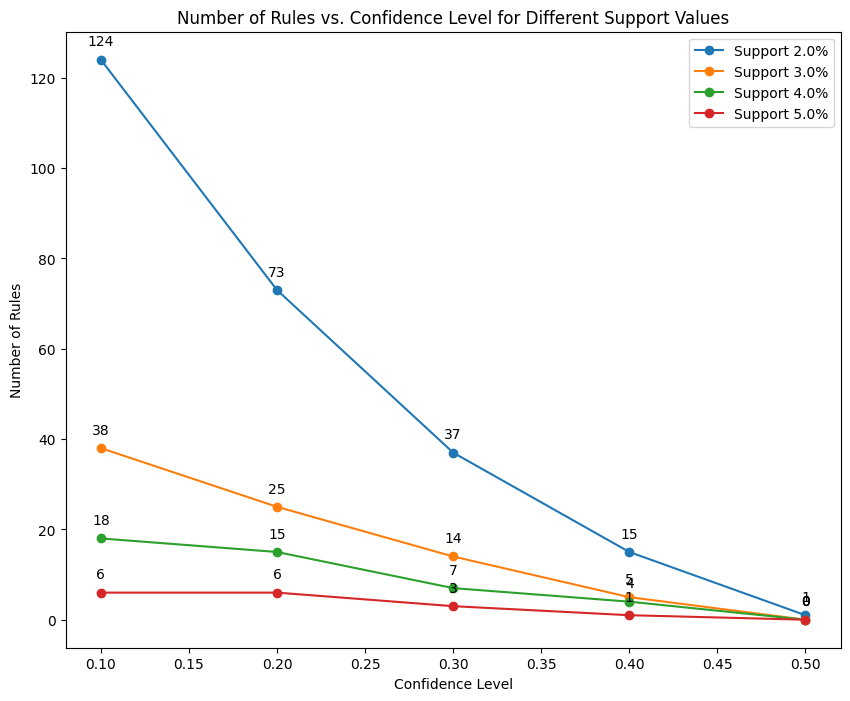

In [46]:
import matplotlib.pyplot as plt

# Load the dataset
dataset = load_dataset('grocery.csv')

# Define the support and confidence levels to test
support_levels = [0.02, 0.03, 0.04, 0.05]
confidence_levels = [0.1, 0.2, 0.3, 0.4, 0.5]

# Prepare the figure
plt.figure(figsize=(10, 8))
plt.title('Number of Rules vs. Confidence Level for Different Support Values')
plt.xlabel('Confidence Level')
plt.ylabel('Number of Rules')

# For each support level, generate rules and count them for each confidence level
for support in support_levels:
    rule_counts = []  # to hold the count of rules for each confidence level
    
    # Get the frequent itemsets and support data for the current support level
    frequent_itemsets, support_data = apriori(dataset, min_support=support, verbose=False)
    
    for confidence in confidence_levels:
        # Generate rules using the frequent itemsets and support data for the current support level
        rules = generate_rules(frequent_itemsets, support_data, min_confidence=confidence, verbose=False)
        rule_count = len(rules)
        rule_counts.append(len(rules))

        # Annotate the data points with the exact number of rules
        plt.annotate(f'{rule_count}', (confidence, rule_count), textcoords="offset points", xytext=(0,10), ha='center')
    
    # Plot the results
    plt.plot(confidence_levels, rule_counts, marker='o', label=f'Support {support*100}%')

# Add legend
plt.legend()

# Show the plot
plt.show()


The outputs of the Apriori algorithm show the variation of minimum support values on the number of frequent itemsets. A lower minimum support value results in more number of itemsets being considered as frequent. This means that more patterns could be found, but it also refers to less common ones that are to be included.

Keeping the minimum confidence constant at 0.5 helped us in focusing on reliable rules. This is because if the value of 0.5 confidence says that half of the time one item is bought, the other is too. It helps in knowing if there are strong links among items without obtaining too many weak associations.

We also observed that 'whole milk', 'rolls/buns' and 'other vegetables' seem to occur again and again. It does show that maybe they are all daily staples in many shopping baskets. Rules involving these items show their importance in customers' purchases.

Lowering min_support also extracted specific rules, such as `{yogurt, whipped/sour cream} -> {whole milk}`. Such insights would assist the store to plan promotions or re-stacking to encourage buying of these items together.

All the items and rules we found show differences in eating habits and preferences. Items such as 'whole milk' and 'yogurt' being common suggest the consumption of dairy products in the region of this dataset.

This exercise is just an example showing how crucial tuning the parameters of the Apriori algorithm is in order to retrieve some useful patterns. It involves some balance between too many rules and really interesting patterns omitted - something that is quite often of high importance in practical analysis.

In summary, shopping behavior analysis with the Apriori algorithm availed an enlightening view of patterns and associations. This demonstrates how data mining reveals hidden relations between the items in the data, helping the business strategies in responding better to the need of the customer.

# FPgrowth

In [30]:
# (c) 2014 Reid Johnson
#
# Modified from:
# Eric Naeseth <eric@naeseth.com>
# (https://github.com/enaeseth/python-fp-growth/blob/master/fp_growth.py)
#
# A Python implementation of the FP-growth algorithm.

from collections import defaultdict, namedtuple
#from itertools import imap

__author__ = 'Eric Naeseth <eric@naeseth.com>'
__copyright__ = 'Copyright © 2009 Eric Naeseth'
__license__ = 'MIT License'

def fpgrowth(dataset, min_support=0.5, include_support=True, verbose=False):
    """Implements the FP-growth algorithm.

    The `dataset` parameter can be any iterable of iterables of items.
    `min_support` should be an integer specifying the minimum number of
    occurrences of an itemset for it to be accepted.

    Each item must be hashable (i.e., it must be valid as a member of a
    dictionary or a set).

    If `include_support` is true, yield (itemset, support) pairs instead of
    just the itemsets.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate 
        candidate itemsets.

    min_support : float
        The minimum support threshold. Defaults to 0.5.

    include_support : bool
        Include support in output (default=False).

    References
    ----------
    .. [1] J. Han, J. Pei, Y. Yin, "Mining Frequent Patterns without Candidate 
           Generation," 2000.

    """

    F = []
    support_data = {}
    for k,v in find_frequent_itemsets(dataset, min_support=min_support, include_support=include_support, verbose=verbose):
        F.append(frozenset(k))
        support_data[frozenset(k)] = v

    # Create one array with subarrays that hold all transactions of equal length.
    def bucket_list(nested_list, sort=True):
        bucket = defaultdict(list)
        for sublist in nested_list:
            bucket[len(sublist)].append(sublist)
        return [v for k,v in sorted(bucket.items())] if sort else bucket.values()

    F = bucket_list(F)
    
    return F, support_data

def find_frequent_itemsets(dataset, min_support, include_support=False, verbose=False):
    """
    Find frequent itemsets in the given transactions using FP-growth. This
    function returns a generator instead of an eagerly-populated list of items.

    The `dataset` parameter can be any iterable of iterables of items.
    `min_support` should be an integer specifying the minimum number of
    occurrences of an itemset for it to be accepted.

    Each item must be hashable (i.e., it must be valid as a member of a
    dictionary or a set).

    If `include_support` is true, yield (itemset, support) pairs instead of
    just the itemsets.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate 
        candidate itemsets.

    min_support : float
        The minimum support threshold. Defaults to 0.5.

    include_support : bool
        Include support in output (default=False).

    """
    items = defaultdict(lambda: 0) # mapping from items to their supports
    processed_transactions = []

    # Load the passed-in transactions and count the support that individual
    # items have.
    for transaction in dataset:
        processed = []
        for item in transaction:
            items[item] += 1
            processed.append(item)
        processed_transactions.append(processed)

    # Remove infrequent items from the item support dictionary.
    items = dict((item, support) for item, support in items.items()
        if support >= min_support)

    # Build our FP-tree. Before any transactions can be added to the tree, they
    # must be stripped of infrequent items and their surviving items must be
    # sorted in decreasing order of frequency.
    def clean_transaction(transaction):
        #transaction = filter(lambda v: v in items, transaction)
        transaction.sort(key=lambda v: items[v], reverse=True)
        return transaction

    master = FPTree()
    for transaction in map(clean_transaction, processed_transactions):
        master.add(transaction)

    support_data = {}
    def find_with_suffix(tree, suffix):
        for item, nodes in tree.items():
            support = float(sum(n.count for n in nodes)) / len(dataset)
            if support >= min_support and item not in suffix:
                # New winner!
                found_set = [item] + suffix
                support_data[frozenset(found_set)] = support
                yield (found_set, support) if include_support else found_set

                # Build a conditional tree and recursively search for frequent
                # itemsets within it.
                cond_tree = conditional_tree_from_paths(tree.prefix_paths(item),
                    min_support)
                for s in find_with_suffix(cond_tree, found_set):
                    yield s # pass along the good news to our caller

    if verbose:
        # Print a list of all the frequent itemsets.
        for itemset, support in find_with_suffix(master, []):
            print("" \
                + "{" \
                + "".join(str(i) + ", " for i in iter(itemset)).rstrip(', ') \
                + "}" \
                + ":  sup = " + str(round(support_data[frozenset(itemset)], 3)))

    # Search for frequent itemsets, and yield the results we find.
    for itemset in find_with_suffix(master, []):
        yield itemset

class FPTree(object):
    """
    An FP tree.

    This object may only store transaction items that are hashable (i.e., all
    items must be valid as dictionary keys or set members).
    """

    Route = namedtuple('Route', 'head tail')

    def __init__(self):
        # The root node of the tree.
        self._root = FPNode(self, None, None)

        # A dictionary mapping items to the head and tail of a path of
        # "neighbors" that will hit every node containing that item.
        self._routes = {}

    @property
    def root(self):
        """The root node of the tree."""
        return self._root

    def add(self, transaction):
        """
        Adds a transaction to the tree.
        """

        point = self._root

        for item in transaction:
            next_point = point.search(item)
            if next_point:
                # There is already a node in this tree for the current
                # transaction item; reuse it.
                next_point.increment()
            else:
                # Create a new point and add it as a child of the point we're
                # currently looking at.
                next_point = FPNode(self, item)
                point.add(next_point)

                # Update the route of nodes that contain this item to include
                # our new node.
                self._update_route(next_point)

            point = next_point

    def _update_route(self, point):
        """Add the given node to the route through all nodes for its item."""
        assert self is point.tree

        try:
            route = self._routes[point.item]
            route[1].neighbor = point # route[1] is the tail
            self._routes[point.item] = self.Route(route[0], point)
        except KeyError:
            # First node for this item; start a new route.
            self._routes[point.item] = self.Route(point, point)

    def items(self):
        """
        Generate one 2-tuples for each item represented in the tree. The first
        element of the tuple is the item itself, and the second element is a
        generator that will yield the nodes in the tree that belong to the item.
        """
        for item in self._routes.keys():
            yield (item, self.nodes(item))

            
    def nodes(self, item):
        """
        Generates the sequence of nodes that contain the given item.
        """

        try:
            node = self._routes[item][0]
        except KeyError:
            return

        while node:
            yield node
            node = node.neighbor

    def prefix_paths(self, item):
        """Generates the prefix paths that end with the given item."""

        def collect_path(node):
            path = []
            while node and not node.root:
                path.append(node)
                node = node.parent
            path.reverse()
            return path

        return (collect_path(node) for node in self.nodes(item))

    def inspect(self):
        print("Tree:")
        self.root.inspect(1)

        print("")
        print("Routes:")
        for item, nodes in self.items():
            print("  %r" % item)
            for node in nodes:
                print("    %r" % node)

    def _removed(self, node):
        """Called when `node` is removed from the tree; performs cleanup."""

        head, tail = self._routes[node.item]
        if node is head:
            if node is tail or not node.neighbor:
                # It was the sole node.
                del self._routes[node.item]
            else:
                self._routes[node.item] = self.Route(node.neighbor, tail)
        else:
            for n in self.nodes(node.item):
                if n.neighbor is node:
                    n.neighbor = node.neighbor # skip over
                    if node is tail:
                        self._routes[node.item] = self.Route(head, n)
                    break

def conditional_tree_from_paths(paths, min_support):
    """Builds a conditional FP-tree from the given prefix paths."""
    tree = FPTree()
    condition_item = None
    items = set()

    # Import the nodes in the paths into the new tree. Only the counts of the
    # leaf notes matter; the remaining counts will be reconstructed from the
    # leaf counts.
    for path in paths:
        if condition_item is None:
            condition_item = path[-1].item

        point = tree.root
        for node in path:
            next_point = point.search(node.item)
            if not next_point:
                # Add a new node to the tree.
                items.add(node.item)
                count = node.count if node.item == condition_item else 0
                next_point = FPNode(tree, node.item, count)
                point.add(next_point)
                tree._update_route(next_point)
            point = next_point

    assert condition_item is not None

    # Calculate the counts of the non-leaf nodes.
    for path in tree.prefix_paths(condition_item):
        count = path[-1].count
        for node in reversed(path[:-1]):
            node._count += count

    # Eliminate the nodes for any items that are no longer frequent.
    for item in items:
        support = sum(n.count for n in tree.nodes(item))
        if support < min_support:
            # Doesn't make the cut anymore
            for node in tree.nodes(item):
                if node.parent is not None:
                    node.parent.remove(node)

    # Finally, remove the nodes corresponding to the item for which this
    # conditional tree was generated.
    for node in tree.nodes(condition_item):
        if node.parent is not None: # the node might already be an orphan
            node.parent.remove(node)

    return tree

class FPNode(object):
    """A node in an FP tree."""

    def __init__(self, tree, item, count=1):
        self._tree = tree
        self._item = item
        self._count = count
        self._parent = None
        self._children = {}
        self._neighbor = None

    def add(self, child):
        """Adds the given FPNode `child` as a child of this node."""

        if not isinstance(child, FPNode):
            raise TypeError("Can only add other FPNodes as children")

        if not child.item in self._children:
            self._children[child.item] = child
            child.parent = self

    def search(self, item):
        """
        Checks to see if this node contains a child node for the given item.
        If so, that node is returned; otherwise, `None` is returned.
        """

        try:
            return self._children[item]
        except KeyError:
            return None

    def remove(self, child):
        try:
            if self._children[child.item] is child:
                del self._children[child.item]
                child.parent = None
                self._tree._removed(child)
                for sub_child in child.children:
                    try:
                        # Merger case: we already have a child for that item, so
                        # add the sub-child's count to our child's count.
                        self._children[sub_child.item]._count += sub_child.count
                        sub_child.parent = None # it's an orphan now
                    except KeyError:
                        # Turns out we don't actually have a child, so just add
                        # the sub-child as our own child.
                        self.add(sub_child)
                child._children = {}
            else:
                raise ValueError("that node is not a child of this node")
        except KeyError:
            raise ValueError("that node is not a child of this node")

    def __contains__(self, item):
        return item in self._children

    @property
    def tree(self):
        """The tree in which this node appears."""
        return self._tree

    @property
    def item(self):
        """The item contained in this node."""
        return self._item

    @property
    def count(self):
        """The count associated with this node's item."""
        return self._count

    def increment(self):
        """Increments the count associated with this node's item."""
        if self._count is None:
            raise ValueError("Root nodes have no associated count.")
        self._count += 1

    @property
    def root(self):
        """True if this node is the root of a tree; false if otherwise."""
        return self._item is None and self._count is None

    @property
    def leaf(self):
        """True if this node is a leaf in the tree; false if otherwise."""
        return len(self._children) == 0

    def parent():
        doc = "The node's parent."
        def fget(self):
            return self._parent
        def fset(self, value):
            if value is not None and not isinstance(value, FPNode):
                raise TypeError("A node must have an FPNode as a parent.")
            if value and value.tree is not self.tree:
                raise ValueError("Cannot have a parent from another tree.")
            self._parent = value
        return locals()
    parent = property(**parent())

    def neighbor():
        doc = """
        The node's neighbor; the one with the same value that is "to the right"
        of it in the tree.
        """
        def fget(self):
            return self._neighbor
        def fset(self, value):
            if value is not None and not isinstance(value, FPNode):
                raise TypeError("A node must have an FPNode as a neighbor.")
            if value and value.tree is not self.tree:
                raise ValueError("Cannot have a neighbor from another tree.")
            self._neighbor = value
        return locals()
    neighbor = property(**neighbor())

    @property
    def children(self):
        """The nodes that are children of this node."""
        return tuple(self._children.values())
        
    def inspect(self, depth=0):
        print(('  ' * depth) + repr(self))
        for child in self.children:
            child.inspect(depth + 1)

    def __repr__(self):
        if self.root:
            return "<%s (root)>" % type(self).__name__
        return "<%s %r (%r)>" % (type(self).__name__, self.item, self.count)

def rules_from_conseq(freq_set, H, support_data, rules, min_confidence=0.5, verbose=False):
    """Generates a set of candidate rules.

    Parameters
    ----------
    freq_set : frozenset
        The complete list of frequent itemsets.

    H : list
        A list of frequent itemsets (of a particular length).

    support_data : dict
        The support data for all candidate itemsets.

    rules : list
        A potentially incomplete set of candidate rules above the minimum 
        confidence threshold.

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.
    """
    m = len(H[0])
    if m == 1:
        Hmp1 = calc_confidence(freq_set, H, support_data, rules, min_confidence, verbose)
    if (len(freq_set) > (m+1)):
        Hmp1 = apriori_gen(H, m+1) # generate candidate itemsets
        Hmp1 = calc_confidence(freq_set, Hmp1,  support_data, rules, min_confidence, verbose)
        if len(Hmp1) > 1:
            # If there are candidate rules above the minimum confidence 
            # threshold, recurse on the list of these candidate rules.
            rules_from_conseq(freq_set, Hmp1, support_data, rules, min_confidence, verbose)

def calc_confidence(freq_set, H, support_data, rules, min_confidence=0.5, verbose=False):
    """Evaluates the generated rules.

    One measurement for quantifying the goodness of association rules is 
    confidence. The confidence for a rule 'P implies H' (P -> H) is defined as 
    the support for P and H divided by the support for P 
    (support (P|H) / support(P)), where the | symbol denotes the set union 
    (thus P|H means all the items in set P or in set H).

    To calculate the confidence, we iterate through the frequent itemsets and 
    associated support data. For each frequent itemset, we divide the support 
    of the itemset by the support of the antecedent (left-hand-side of the 
    rule).

    Parameters
    ----------
    freq_set : frozenset
        The complete list of frequent itemsets.

    H : list
        A list of frequent itemsets (of a particular length).

    min_support : float
        The minimum support threshold.

    rules : list
        A potentially incomplete set of candidate rules above the minimum 
        confidence threshold.

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.

    Returns
    -------
    pruned_H : list
        The list of candidate rules above the minimum confidence threshold.
    """
    pruned_H = [] # list of candidate rules above the minimum confidence threshold
    for conseq in H: # iterate over the frequent itemsets
        conf = support_data[freq_set] / support_data[freq_set - conseq]
        if conf >= min_confidence:
            rules.append((freq_set - conseq, conseq, conf))
            pruned_H.append(conseq)

            if verbose:
                print("" \
                    + "{" \
                    + "".join([str(i) + ", " for i in iter(freq_set-conseq)]).rstrip(', ') \
                    + "}" \
                    + " ---> " \
                    + "{" \
                    + "".join([str(i) + ", " for i in iter(conseq)]).rstrip(', ') \
                    + "}" \
                    + ":  conf = " + str(round(conf, 3)) \
                    + ", sup = " + str(round(support_data[freq_set], 3)))

    return pruned_H

def generate_rules(F, support_data, min_confidence=0.5, verbose=True):
    """Generates a set of candidate rules from a list of frequent itemsets.

    For each frequent itemset, we calculate the confidence of using a
    particular item as the rule consequent (right-hand-side of the rule). By 
    testing and merging the remaining rules, we recursively create a list of 
    pruned rules.

    Parameters
    ----------
    F : list
        A list of frequent itemsets.

    support_data : dict
        The corresponding support data for the frequent itemsets (L).

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.

    Returns
    -------
    rules : list
        The list of candidate rules above the minimum confidence threshold.
    """
    rules = []
    for i in range(1, len(F)):
        for freq_set in F[i]:
            H1 = [frozenset([item]) for item in freq_set]
            if (i > 1):
                rules_from_conseq(freq_set, H1, support_data, rules, min_confidence, verbose)
            else:
                calc_confidence(freq_set, H1, support_data, rules, min_confidence, verbose)

    return rules

In [31]:
import csv

def load_dataset(filename):
    transactions = []
    with open(filename, 'r', encoding='utf-8') as file:
        data_iter = csv.reader(file, delimiter=',', quotechar='"')
        for row in data_iter:
            # Convert each row to a set to handle variable-length transactions
            transactions.append(set(row))
    return transactions

# Path to the grocery dataset CSV file
file_path = 'grocery.csv'

# Load the dataset
dataset = load_dataset(file_path)
D = list(map(set, dataset))

In [39]:
# Define your support threshold
min_support = 0.05  # 5% support
min_confidence = 0.5  # minimum confidence for the rules

# Generate frequent itemsets using FP-growth
frequent_itemsets, support_data = fpgrowth(dataset, min_support=min_support, include_support=True, verbose=True)

# Generate association rules from the frequent itemsets
rules = generate_rules(frequent_itemsets, support_data, min_confidence=min_confidence, verbose=True)

# Print out the rules
for rule in rules:
    print(rule)

{citrus fruit}:  sup = 0.083
{margarine}:  sup = 0.059
{yogurt}:  sup = 0.14
{whole milk, yogurt}:  sup = 0.056
{tropical fruit}:  sup = 0.105
{coffee}:  sup = 0.058
{whole milk}:  sup = 0.256
{pip fruit}:  sup = 0.076
{other vegetables}:  sup = 0.193
{whole milk, other vegetables}:  sup = 0.075
{butter}:  sup = 0.055
{rolls/buns}:  sup = 0.184
{whole milk, rolls/buns}:  sup = 0.057
{bottled beer}:  sup = 0.081
{bottled water}:  sup = 0.111
{curd}:  sup = 0.053
{beef}:  sup = 0.052
{soda}:  sup = 0.174
{frankfurter}:  sup = 0.059
{newspapers}:  sup = 0.08
{fruit/vegetable juice}:  sup = 0.072
{pastry}:  sup = 0.089
{root vegetables}:  sup = 0.109
{canned beer}:  sup = 0.078
{sausage}:  sup = 0.094
{shopping bags}:  sup = 0.099
{brown bread}:  sup = 0.065
{napkins}:  sup = 0.052
{whipped/sour cream}:  sup = 0.072
{pork}:  sup = 0.058
{domestic eggs}:  sup = 0.063


In [40]:
# Define your support threshold
min_support = 0.04  # 4% support
min_confidence = 0.5  # minimum confidence for the rules

# Generate frequent itemsets using FP-growth
frequent_itemsets, support_data = fpgrowth(dataset, min_support=min_support, include_support=True, verbose=True)

# Generate association rules from the frequent itemsets
rules = generate_rules(frequent_itemsets, support_data, min_confidence=min_confidence, verbose=True)

# Print out the rules
for rule in rules:
    print(rule)

{citrus fruit}:  sup = 0.083
{margarine}:  sup = 0.059
{yogurt}:  sup = 0.14
{whole milk, yogurt}:  sup = 0.056
{other vegetables, yogurt}:  sup = 0.043
{tropical fruit}:  sup = 0.105
{whole milk, tropical fruit}:  sup = 0.042
{coffee}:  sup = 0.058
{whole milk}:  sup = 0.256
{pip fruit}:  sup = 0.076
{other vegetables}:  sup = 0.193
{whole milk, other vegetables}:  sup = 0.075
{butter}:  sup = 0.055
{rolls/buns}:  sup = 0.184
{other vegetables, rolls/buns}:  sup = 0.043
{whole milk, rolls/buns}:  sup = 0.057
{bottled beer}:  sup = 0.081
{bottled water}:  sup = 0.111
{chocolate}:  sup = 0.05
{white bread}:  sup = 0.042
{curd}:  sup = 0.053
{beef}:  sup = 0.052
{soda}:  sup = 0.174
{whole milk, soda}:  sup = 0.04
{frankfurter}:  sup = 0.059
{chicken}:  sup = 0.043
{newspapers}:  sup = 0.08
{fruit/vegetable juice}:  sup = 0.072
{pastry}:  sup = 0.089
{root vegetables}:  sup = 0.109
{other vegetables, root vegetables}:  sup = 0.047
{whole milk, root vegetables}:  sup = 0.049
{canned beer}

In [41]:
# Define your support threshold
min_support = 0.03  # 3% support
min_confidence = 0.5  # minimum confidence for the rules

# Generate frequent itemsets using FP-growth
frequent_itemsets, support_data = fpgrowth(dataset, min_support=min_support, include_support=True, verbose=True)

# Generate association rules from the frequent itemsets
rules = generate_rules(frequent_itemsets, support_data, min_confidence=min_confidence, verbose=True)

# Print out the rules
for rule in rules:
    print(rule)

{citrus fruit}:  sup = 0.083
{whole milk, citrus fruit}:  sup = 0.031
{margarine}:  sup = 0.059
{yogurt}:  sup = 0.14
{whole milk, yogurt}:  sup = 0.056
{rolls/buns, yogurt}:  sup = 0.034
{other vegetables, yogurt}:  sup = 0.043
{tropical fruit}:  sup = 0.105
{other vegetables, tropical fruit}:  sup = 0.036
{whole milk, tropical fruit}:  sup = 0.042
{coffee}:  sup = 0.058
{whole milk}:  sup = 0.256
{pip fruit}:  sup = 0.076
{whole milk, pip fruit}:  sup = 0.03
{cream cheese}:  sup = 0.04
{other vegetables}:  sup = 0.193
{whole milk, other vegetables}:  sup = 0.075
{long life bakery product}:  sup = 0.037
{butter}:  sup = 0.055
{rolls/buns}:  sup = 0.184
{other vegetables, rolls/buns}:  sup = 0.043
{whole milk, rolls/buns}:  sup = 0.057
{bottled beer}:  sup = 0.081
{UHT-milk}:  sup = 0.033
{bottled water}:  sup = 0.111
{whole milk, bottled water}:  sup = 0.034
{chocolate}:  sup = 0.05
{white bread}:  sup = 0.042
{curd}:  sup = 0.053
{beef}:  sup = 0.052
{soda}:  sup = 0.174
{rolls/buns,

In [42]:
# Define your support threshold
min_support = 0.02  # 2% support
min_confidence = 0.5  # minimum confidence for the rules

# Generate frequent itemsets using FP-growth
frequent_itemsets, support_data = fpgrowth(dataset, min_support=min_support, include_support=True, verbose=True)

# Generate association rules from the frequent itemsets
rules = generate_rules(frequent_itemsets, support_data, min_confidence=min_confidence, verbose=True)

# Print out the rules
for rule in rules:
    print(rule)

{citrus fruit}:  sup = 0.083
{whole milk, citrus fruit}:  sup = 0.031
{yogurt, citrus fruit}:  sup = 0.022
{other vegetables, citrus fruit}:  sup = 0.029
{margarine}:  sup = 0.059
{whole milk, margarine}:  sup = 0.024
{yogurt}:  sup = 0.14
{whole milk, yogurt}:  sup = 0.056
{soda, yogurt}:  sup = 0.027
{rolls/buns, yogurt}:  sup = 0.034
{other vegetables, yogurt}:  sup = 0.043
{whole milk, other vegetables, yogurt}:  sup = 0.022
{tropical fruit}:  sup = 0.105
{yogurt, tropical fruit}:  sup = 0.029
{other vegetables, tropical fruit}:  sup = 0.036
{whole milk, tropical fruit}:  sup = 0.042
{rolls/buns, tropical fruit}:  sup = 0.025
{root vegetables, tropical fruit}:  sup = 0.021
{soda, tropical fruit}:  sup = 0.021
{coffee}:  sup = 0.058
{whole milk}:  sup = 0.256
{pip fruit}:  sup = 0.076
{whole milk, pip fruit}:  sup = 0.03
{tropical fruit, pip fruit}:  sup = 0.02
{other vegetables, pip fruit}:  sup = 0.026
{cream cheese}:  sup = 0.04
{other vegetables}:  sup = 0.193
{whole milk, other

In [43]:
# Define your support threshold
min_support = 0.01  # 1% support
min_confidence = 0.5  # minimum confidence for the rules

# Generate frequent itemsets using FP-growth
frequent_itemsets, support_data = fpgrowth(dataset, min_support=min_support, include_support=True, verbose=True)

# Generate association rules from the frequent itemsets
rules = generate_rules(frequent_itemsets, support_data, min_confidence=min_confidence, verbose=True)

# Print out the rules
for rule in rules:
    print(rule)

{citrus fruit}:  sup = 0.083
{whole milk, citrus fruit}:  sup = 0.031
{yogurt, citrus fruit}:  sup = 0.022
{whole milk, yogurt, citrus fruit}:  sup = 0.01
{bottled water, citrus fruit}:  sup = 0.014
{tropical fruit, citrus fruit}:  sup = 0.02
{other vegetables, citrus fruit}:  sup = 0.029
{whole milk, other vegetables, citrus fruit}:  sup = 0.013
{root vegetables, citrus fruit}:  sup = 0.018
{other vegetables, root vegetables, citrus fruit}:  sup = 0.01
{sausage, citrus fruit}:  sup = 0.011
{rolls/buns, citrus fruit}:  sup = 0.017
{soda, citrus fruit}:  sup = 0.013
{margarine}:  sup = 0.059
{other vegetables, margarine}:  sup = 0.02
{whole milk, margarine}:  sup = 0.024
{rolls/buns, margarine}:  sup = 0.015
{root vegetables, margarine}:  sup = 0.011
{bottled water, margarine}:  sup = 0.01
{yogurt, margarine}:  sup = 0.014
{soda, margarine}:  sup = 0.01
{semi-finished bread}:  sup = 0.018
{yogurt}:  sup = 0.14
{whole milk, yogurt}:  sup = 0.056
{soda, yogurt}:  sup = 0.027
{whole milk, 

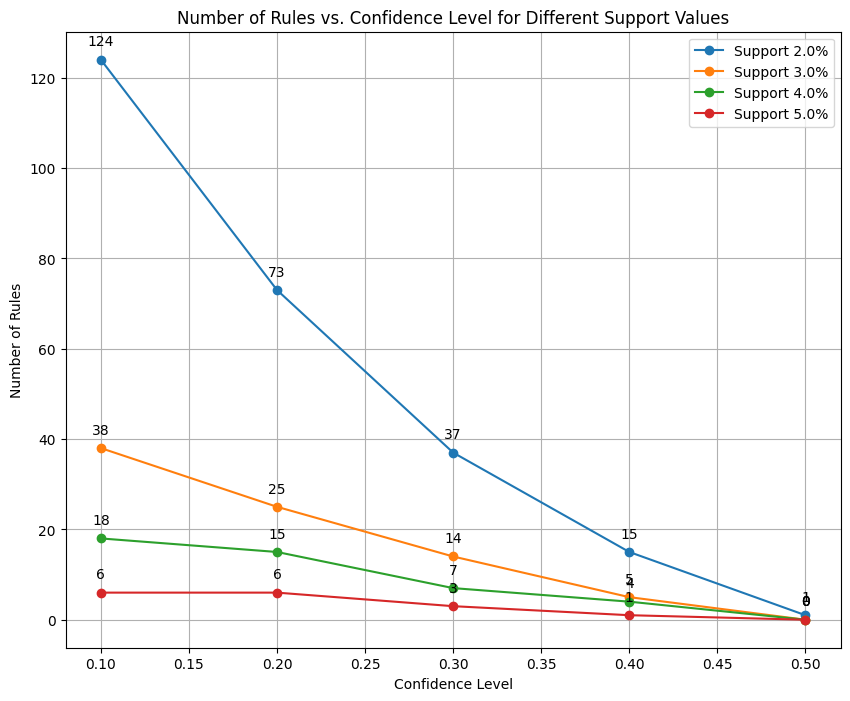

In [45]:
import matplotlib.pyplot as plt

# Define the support and confidence levels to test
support_levels = [0.02, 0.03, 0.04, 0.05]
confidence_levels = [0.1, 0.2, 0.3, 0.4, 0.5]

# Prepare the figure
plt.figure(figsize=(10, 8))
plt.title('Number of Rules vs. Confidence Level for Different Support Values')
plt.xlabel('Confidence Level')
plt.ylabel('Number of Rules')

# For each support level, generate rules and count them for each confidence level
for support in support_levels:
    rule_counts = []  # to hold the count of rules for each confidence level
    
    # Get the frequent itemsets and support data for the current support level
    frequent_itemsets, support_data = fpgrowth(dataset, min_support=support, verbose=False)
    
    for confidence in confidence_levels:
        # Generate rules using the frequent itemsets and support data for the current support level
        rules = generate_rules(frequent_itemsets, support_data, min_confidence=confidence, verbose=False)
        rule_count = len(rules)
        rule_counts.append(rule_count)
        
        # Annotate the data points with the exact number of rules
        plt.annotate(f'{rule_count}', (confidence, rule_count), textcoords="offset points", xytext=(0,10), ha='center')
    
    # Plot the results
    plt.plot(confidence_levels, rule_counts, marker='o', label=f'Support {support*100}%')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


By lowering the minimum support value in the FP-growth algorithm, more item combinations are considered frequent, revealing a wider range of purchasing patterns among consumers. This adjustment allows for the identification of both common and less frequent item sets that are significant for understanding customer behavior.

Keeping the minimum confidence constant at 0.5 highlights only the strongest associations between items, such as yogurt and vegetables often leading to the purchase of whole milk. These findings provide insights into the most reliable buying patterns observed in the data.

The results showcase common shopping habits, indicating that items like whole milk, vegetables, and yogurt are often bought together. Such information can guide retailers in creating effective cross-selling strategies and optimizing store layouts to enhance customer experiences.

Adjusting the minimum support threshold uncovers a spectrum of consumer behaviors, from widely observed to niche patterns. This knowledge is crucial for retailers aiming to implement targeted marketing strategies, improve product placement, and ultimately, cater to diverse customer preferences.

In [66]:
# Define your support threshold
min_support = 0.02  # 2% support
min_confidence = 0.3  # minimum confidence for the rules

# Generate frequent itemsets using FP-growth
frequent_itemsets, support_data = fpgrowth(dataset, min_support=min_support, include_support=True, verbose=True)

# Generate association rules from the frequent itemsets
rules = generate_rules(frequent_itemsets, support_data, min_confidence=min_confidence, verbose=True)

# Print out the rules
for rule in rules:
    print(rule)

#print(support_data)

{citrus fruit}:  sup = 0.083
{whole milk, citrus fruit}:  sup = 0.031
{yogurt, citrus fruit}:  sup = 0.022
{other vegetables, citrus fruit}:  sup = 0.029
{margarine}:  sup = 0.059
{whole milk, margarine}:  sup = 0.024
{yogurt}:  sup = 0.14
{whole milk, yogurt}:  sup = 0.056
{soda, yogurt}:  sup = 0.027
{rolls/buns, yogurt}:  sup = 0.034
{other vegetables, yogurt}:  sup = 0.043
{whole milk, other vegetables, yogurt}:  sup = 0.022
{tropical fruit}:  sup = 0.105
{yogurt, tropical fruit}:  sup = 0.029
{other vegetables, tropical fruit}:  sup = 0.036
{whole milk, tropical fruit}:  sup = 0.042
{rolls/buns, tropical fruit}:  sup = 0.025
{root vegetables, tropical fruit}:  sup = 0.021
{soda, tropical fruit}:  sup = 0.021
{coffee}:  sup = 0.058
{whole milk}:  sup = 0.256
{pip fruit}:  sup = 0.076
{whole milk, pip fruit}:  sup = 0.03
{tropical fruit, pip fruit}:  sup = 0.02
{other vegetables, pip fruit}:  sup = 0.026
{cream cheese}:  sup = 0.04
{other vegetables}:  sup = 0.193
{whole milk, other

In [81]:

# Define a function to calculate the interest factor
def calculate_interest_factor(rule, support_data):
    """
    Interest Factor is defined as |confidence - expected_confidence|.
    Expected confidence is the support of the consequent divided by the total number of transactions.
    """
    support_antecedent = support_data[rule[0]]
    support_consequent = support_data[rule[1]]
    support_both = support_data[rule[0] | rule[1]]
    confidence = support_both / support_antecedent
    expected_confidence = support_consequent
    interest_factor = abs(confidence - expected_confidence)
    return interest_factor


# Update each rule tuple with the interest factor
rules_with_interest = []
for rule in rules:
    # Calculate the interest factor for the rule
    interest_factor = calculate_interest_factor(rule, support_data)
    # Append the interest factor to the rule's tuple
    updated_rule = rule + (interest_factor,)
    rules_with_interest.append(updated_rule)

# Print out the rules
for rule in rules_with_interest:
    print(rule)

(frozenset({'citrus fruit'}), frozenset({'whole milk'}), 0.36855036855036855, 0.11303435431549308)
(frozenset({'citrus fruit'}), frozenset({'other vegetables'}), 0.34889434889434895, 0.15540172052627574)
(frozenset({'margarine'}), frozenset({'whole milk'}), 0.4131944444444444, 0.15767843020956895)
(frozenset({'yogurt'}), frozenset({'whole milk'}), 0.40160349854227406, 0.1460874843073986)
(frozenset({'yogurt'}), frozenset({'other vegetables'}), 0.3112244897959184, 0.11773186142784517)
(frozenset({'tropical fruit'}), frozenset({'other vegetables'}), 0.34205426356589147, 0.14856163519781826)
(frozenset({'tropical fruit'}), frozenset({'whole milk'}), 0.40310077519379844, 0.14758476095892298)
(frozenset({'pip fruit'}), frozenset({'whole milk'}), 0.3978494623655914, 0.1423334481307159)
(frozenset({'pip fruit'}), frozenset({'other vegetables'}), 0.3454301075268817, 0.15193747915880848)
(frozenset({'other vegetables'}), frozenset({'whole milk'}), 0.38675775091960063, 0.13124173668472516)
(froz

In [91]:
# Sort the rules by support, confidence, and interest factor, respectively
# Here we need to ensure we're using the correct indices for support and confidence
rules_by_support = sorted(rules_with_interest, key=lambda r: support_data[r[0] | r[1]], reverse=True)
rules_by_confidence = sorted(rules_with_interest, key=lambda r: r[2], reverse=True)
rules_by_interest_factor = sorted(rules_with_interest, key=lambda r: r[3], reverse=True)

# Print the top-5 rules for each sorted list
print("Top 5 Rules by Support:")
for rule in rules_by_support[:5]:
    print(rule)

print("\nTop 5 Rules by Confidence:")
for rule in rules_by_confidence[:5]:
    print(rule)

print("\nTop 5 Rules by Interest Factor:")
for rule in rules_by_interest_factor[:5]:
    print(rule)


Top 5 Rules by Support:
(frozenset({'other vegetables'}), frozenset({'whole milk'}), 0.38675775091960063, 0.13124173668472516)
(frozenset({'rolls/buns'}), frozenset({'whole milk'}), 0.30790491984521834, 0.05238890561034287)
(frozenset({'yogurt'}), frozenset({'whole milk'}), 0.40160349854227406, 0.1460874843073986)
(frozenset({'root vegetables'}), frozenset({'whole milk'}), 0.44869402985074625, 0.19317801561587078)
(frozenset({'root vegetables'}), frozenset({'other vegetables'}), 0.43470149253731344, 0.24120886416924023)

Top 5 Rules by Confidence:
(frozenset({'yogurt', 'other vegetables'}), frozenset({'whole milk'}), 0.5128805620608898, 0.25736454782601437)
(frozenset({'butter'}), frozenset({'whole milk'}), 0.4972477064220184, 0.2417316921871429)
(frozenset({'curd'}), frozenset({'whole milk'}), 0.4904580152671756, 0.23494200103230012)
(frozenset({'other vegetables', 'root vegetables'}), frozenset({'whole milk'}), 0.4892703862660944, 0.23375437203121896)
(frozenset({'root vegetables', '

In [99]:
# Extract just the antecedent and consequent parts of the rules for comparison
top5_support_rules = {(rule[0], rule[1]) for rule in rules_by_support[:5]}
top5_confidence_rules = {(rule[0], rule[1]) for rule in rules_by_confidence[:5]}
top5_interest_factor_rules = {(rule[0], rule[1]) for rule in rules_by_interest_factor[:5]}

# Find common rules based on antecedent and consequent
common_rule_bases = top5_support_rules & top5_interest_factor_rules

# Now find the full rule info (with support and interest factor) for the common rules
common_rules_full_info = [rule for rule in rules_with_interest if (rule[0], rule[1]) in common_rule_bases]

# Print the common rules with full information
print("\nCommon Rules in Top 5 of support and interest factor:")
for rule in common_rules_full_info:
    print(rule)


Common Rules in Top 5 of support and interest factor:
(frozenset({'root vegetables'}), frozenset({'other vegetables'}), 0.43470149253731344, 0.24120886416924023)


In [100]:
# Find common rules based on antecedent and consequent
common_rule_bases = top5_confidence_rules & top5_interest_factor_rules

# Now find the full rule info (with confidence and interest factor) for the common rules
common_rules_full_info = [rule for rule in rules_with_interest if (rule[0], rule[1]) in common_rule_bases]

# Print the common rules with full information
print("\nCommon Rules in Top 5 of confidence and interest factor:")
for rule in common_rules_full_info:
    print(rule)


Common Rules in Top 5 of confidence and interest factor:
(frozenset({'butter'}), frozenset({'whole milk'}), 0.4972477064220184, 0.2417316921871429)
(frozenset({'curd'}), frozenset({'whole milk'}), 0.4904580152671756, 0.23494200103230012)
(frozenset({'yogurt', 'other vegetables'}), frozenset({'whole milk'}), 0.5128805620608898, 0.25736454782601437)
(frozenset({'root vegetables', 'whole milk'}), frozenset({'other vegetables'}), 0.47401247401247404, 0.2805198456444008)


In [101]:
# Find common rules based on antecedent and consequent
common_rule_bases = top5_support_rules & top5_confidence_rules

# Now find the full rule info (with support and confidence) for the common rules
common_rules_full_info = [rule for rule in rules_with_interest if (rule[0], rule[1]) in common_rule_bases]

# Print the common rules with full information
print("\nCommon Rules in Top 5 of support and confidence:")
for rule in common_rules_full_info:
    print(rule)


Common Rules in Top 5 of support and confidence:


In [102]:
# Find common rules based on antecedent and consequent
common_rule_bases = top5_support_rules & top5_confidence_rules & top5_interest_factor_rules

# Now find the full rule info (with support, confidence, and interest factor) for the common rules
common_rules_full_info = [rule for rule in rules_with_interest if (rule[0], rule[1]) in common_rule_bases]

# Print the common rules with full information
print("\nCommon Rules in Top 5:")
for rule in common_rules_full_info:
    print(rule)


Common Rules in Top 5:


There are no common rules across all three top 5 lists, but there are four common rules between top 5 confidence and interest factor and 1 common rule between top 5 support and interest factor